# **Imports 📢**

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms, datasets
from torchvision.utils import make_grid, save_image
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from torch import  nn
from torch.autograd import Variable

# **Inits 👶**

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 100

mnist_dim = 784

lr = 0.0002

n_epochs = 150

# **Utils 🧰**

In [3]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# **Dataset 📚**

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(0.5, 0.5)])

In [5]:
dataset = MNIST('./mnist', train=True, download=True, transform=transform)
dataset

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16002549.30it/s]


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 492271.44it/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3864485.73it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4163140.03it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [6]:
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
dataloader

In [7]:
x, y = next(iter(dataloader))

x.shape, y

(torch.Size([100, 1, 28, 28]),
 tensor([6, 7, 6, 9, 3, 0, 9, 9, 3, 8, 6, 6, 4, 8, 5, 7, 2, 6, 8, 9, 1, 8, 7, 8,
         7, 4, 3, 3, 5, 6, 7, 4, 9, 7, 7, 1, 4, 5, 4, 6, 0, 1, 4, 0, 8, 9, 3, 0,
         9, 2, 3, 2, 4, 1, 7, 9, 5, 4, 3, 1, 0, 2, 2, 1, 9, 3, 3, 1, 8, 0, 3, 0,
         9, 3, 6, 3, 9, 0, 3, 7, 8, 6, 0, 7, 8, 9, 6, 9, 1, 5, 8, 7, 4, 4, 9, 1,
         5, 2, 2, 3]))

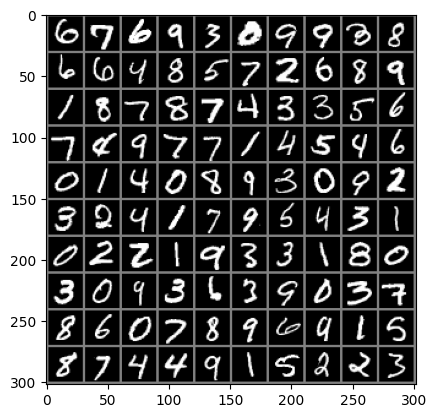

In [8]:
plt.imshow(make_grid(x, 10)[0], cmap='gray')

# **Models 🤼‍♂️**

## Generator🧙‍♂️

In [18]:
class Generator(nn.Module):
  def __init__(self, n=256):
    super(Generator, self).__init__()

    self.fc1 = nn.LazyLinear(n)
    self.fc2 = nn.LazyLinear(n*2)
    self.fc3 = nn.LazyLinear(n*4)
    self.fc4 = nn.LazyLinear(mnist_dim)

  def forward(self, x, labels):

    labels = F.one_hot(labels, num_classes=10)
    x = torch.cat([x, labels], dim=1)

    x = F.leaky_relu(self.fc1(x), 0.2)
    x = F.leaky_relu(self.fc2(x), 0.2)
    x = F.leaky_relu(self.fc3(x), 0.2)
    y = torch.tanh(self.fc4(x))

    return y

## Discriminator 🕵️‍♂️

In [19]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.fc1 = nn.LazyLinear(1024)
    self.fc2 = nn.LazyLinear(512)
    self.fc3 = nn.LazyLinear(256)
    self.fc4 = nn.LazyLinear(1)

  def forward(self, x, labels):

    labels = F.one_hot(labels, num_classes=10)
    x = torch.cat([x, labels], dim=1)

    x = F.dropout(F.leaky_relu(self.fc1(x), 0.2), 0.3)
    x = F.dropout(F.leaky_relu(self.fc2(x), 0.2), 0.3)
    x = F.dropout(F.leaky_relu(self.fc3(x), 0.2), 0.3)
    y = torch.sigmoid(self.fc4(x))

    return y

## Build models and chek them

In [20]:
#Gen
Gen = Generator().to(device)
Gen

Generator(
  (fc1): LazyLinear(in_features=0, out_features=256, bias=True)
  (fc2): LazyLinear(in_features=0, out_features=512, bias=True)
  (fc3): LazyLinear(in_features=0, out_features=1024, bias=True)
  (fc4): LazyLinear(in_features=0, out_features=784, bias=True)
)

In [21]:
#Disc
Disc = Discriminator().to(device)
Disc

Discriminator(
  (fc1): LazyLinear(in_features=0, out_features=1024, bias=True)
  (fc2): LazyLinear(in_features=0, out_features=512, bias=True)
  (fc3): LazyLinear(in_features=0, out_features=256, bias=True)
  (fc4): LazyLinear(in_features=0, out_features=1, bias=True)
)

# **Loss & Optimizers ⚖️**

In [23]:
loss_fn = nn.BCELoss()

In [24]:
G_optimizer = optim.Adam(Gen.parameters(), lr=lr)
D_optimizer = optim.Adam(Disc.parameters(), lr=lr)

# **Train 🚅**

In [25]:
loss_D_hist, loss_G_hist = [], []

In [26]:
for epoch in range(n_epochs):
  loss_D_avg, loss_G_avg = AverageMeter(), AverageMeter()
  for x, y in dataloader:
    # noise & fake label
    noise = torch.randn(batch_size,100).to(device)
    fake_labels = torch.randint(0, 10, (batch_size,)).to(device)
    generated_data = Gen(noise, fake_labels) # batch_size X 784
    #----------------------------------------------------------------------
    # Discriminator
    #----------------------------------------------------------------------
    Disc.zero_grad()

    # real data
    real_data = x.view(batch_size, 784).to(device)
    digit_labels = y.to(device) # batch_size
    real_labels = torch.ones(batch_size, 1).to(device)

    # real,digit_labels -> D
    D_output = Disc(real_data, digit_labels)
    real_discriminator_loss = loss_fn(D_output, real_labels)



    # (generated data, fake_labels) -> D
    discriminator_output_for_generated_data = Disc(generated_data, fake_labels)

    generator_discriminator_loss = loss_fn(discriminator_output_for_generated_data, torch.zeros(batch_size, 1).to(device))

    discriminator_loss = (real_discriminator_loss + generator_discriminator_loss) / 2

    # optimization And backward
    discriminator_loss.backward()
    D_optimizer.step()

    #----------------------------------------------------------------------
    # Generator
    #----------------------------------------------------------------------
    Gen.zero_grad()
    # noise, fake_labels > G
    noise = torch.randn(batch_size, 100).to(device)
    real_labels = torch.ones(batch_size, 1).to(device)
    generated_data = Gen(noise, fake_labels)

    # generated_data,fake_labels -> D
    discriminator_output_on_generated_data = Disc(generated_data, fake_labels)

    # loss
    G_loss = loss_fn(discriminator_output_on_generated_data, real_labels)

    # optimization And backward
    G_loss.backward()
    G_optimizer.step()

    loss_D_avg.update(discriminator_loss.item())
    loss_G_avg.update(G_loss.item())

  loss_D_hist.append(loss_D_avg.avg)
  loss_G_hist.append(loss_G_avg.avg)

  print(f'{epoch}/{n_epochs}: D Loss: {loss_D_avg.avg:.4f}, G Loss: {loss_G_avg.avg:.4f}')

0/150: D Loss: 0.4947, G Loss: 2.6304
1/150: D Loss: 0.4510, G Loss: 2.2627
2/150: D Loss: 0.3672, G Loss: 2.7815
3/150: D Loss: 0.2418, G Loss: 3.0721
4/150: D Loss: 0.2820, G Loss: 2.8676
5/150: D Loss: 0.2475, G Loss: 3.0633
6/150: D Loss: 0.2753, G Loss: 2.6417
7/150: D Loss: 0.2486, G Loss: 2.9824
8/150: D Loss: 0.2738, G Loss: 2.7950
9/150: D Loss: 0.2964, G Loss: 2.6015
10/150: D Loss: 0.3222, G Loss: 2.4715
11/150: D Loss: 0.3624, G Loss: 2.1040
12/150: D Loss: 0.3912, G Loss: 2.0108
13/150: D Loss: 0.4048, G Loss: 1.8581
14/150: D Loss: 0.4049, G Loss: 1.8590
15/150: D Loss: 0.4269, G Loss: 1.7584
16/150: D Loss: 0.4277, G Loss: 1.7647
17/150: D Loss: 0.4229, G Loss: 1.8112
18/150: D Loss: 0.4343, G Loss: 1.7348
19/150: D Loss: 0.4544, G Loss: 1.6464
20/150: D Loss: 0.4472, G Loss: 1.6696
21/150: D Loss: 0.4649, G Loss: 1.5574
22/150: D Loss: 0.4714, G Loss: 1.5558
23/150: D Loss: 0.4765, G Loss: 1.5457
24/150: D Loss: 0.4780, G Loss: 1.5254
25/150: D Loss: 0.4917, G Loss: 1.4

# **Plot 📈**

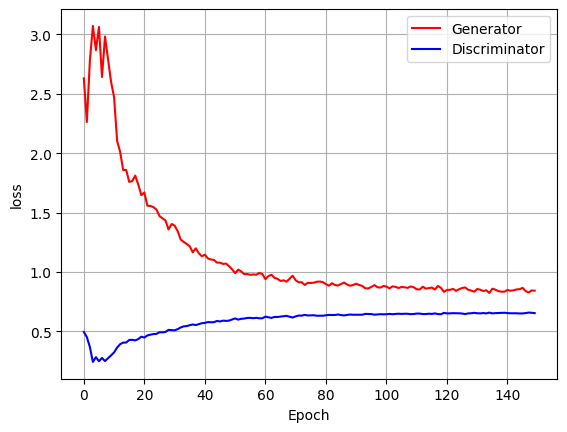

In [27]:
plt.plot(range(n_epochs), loss_G_hist, 'r-', label='Generator')
plt.plot(range(n_epochs), loss_D_hist, 'b-', label='Discriminator')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# **Save 💰**

In [28]:
torch.save(Gen, './generator.pt')

# **Evaluation ❓**

In [30]:
generator_model = torch.load('./generator.pt')
with torch.no_grad():
  bs = 5
  test_z = torch.randn(bs, 100).to(device)
  label = torch.tensor([6, 4, 8, 0, 1]).to(device)
  outputs = generator_model(test_z, label)
  save_image(outputs.view(bs, 1, 28, 28), './output/gan_output.png')

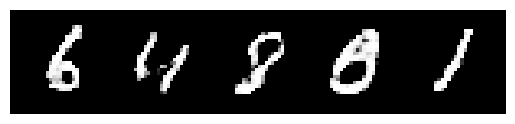

In [32]:
plt.imshow(mpimg.imread('./output/gan_output.png'))
plt.axis('off');